
# Fundamentos de bases de datos
## Laboratorio 2022 - Tarea 3

**Objetivos:** 

* Experimentar y analizar las consecuencias ocasionadas por problemas en el diseño de bases de datos relacionales.
* Poner en práctica las técnicas y algoritmos de diseño y normalización

En esta tarea vamos a partir de una porción de la realidad descripta en la tarea 1. Se presentará un primer diseño relacional que tiene problemas. Realizaremos consultas que mostrarán algunas de las consecuencias de esos problemas y por último se presentarán escenarios donde se deberá proponer un nuevo diseño que solucione los problemas que allí se encuentren.

**Referencias y material de consulta**

- Material del curso de Fundamentos de Bases de datos sobre diseño relacional
- [EN, 2016] Capítulos 14 y 15, Fundamentals of Database Systems, Elmasri & Navathe, 7th Edition, Pearson, 2016
- [Documentación de PostgreSQL sobre Triggers](https://www.postgresql.org/docs/14/triggers.html)


**Entrega:** Realizar todas las actividades que se describen en este notebook. Si es necesario, se pueden agregar más celdas tanto de tipo markdown como código. Se pide entregar:
1. el `notebook modificado` que refleje el trabajo realizado por el grupo, incluyendo respuestas, explicaciones y el código generado, y
2. el `pdf` correspondiente al notebook entregado

**IMPORTANTE:** 
1. Comprobar antes de realizar la entrega final, haber completado la primera sección "Datos del grupo"
2. Para las consultas SQL **no se podrán utilizar** subconsultas en el `FROM` ni en el `SELECT`. Tampoco `vistas` ni la cláusula `WITH`.

**PLAZO DE ENTREGA:** lunes 24/10/2022 23:59


# Datos del grupo

**Identificación del grupo:** bdatos50
    
**Integrantes:**
* Natalie Valentina Alaniz Ferreira, 5.209.018-4
* Facundo Díaz Rodriguez, 5.053.849-3
* Agustín Matías Martínez Acuña, 5.074.743-0

## Descripción de la realidad 

Se trabajará con una parte de la realidad descripta en la tarea 1. Nos focalizaremos en las sagas y sus películas. Las calificaciones de las películas por parte de las personas suscriptas a las plataformas. Las personas que trabajan en los episodios de temporadas de las series. Contemplaremos un cambio pedido por nuestro cliente respecto a las calificaciones. Se permitirá que una persona suscripta en una plataforma pueda realizar más de una calificación a la misma pelicula pero sólo en fechas diferentes. Para ello se introduce la fecha de la calificación. 

A continuación, se presenta el Modelo Entidad-Relación de `miniMovies` representando a esta realidad, comenzando por el Diagrama de Entidad-Relación (DER):


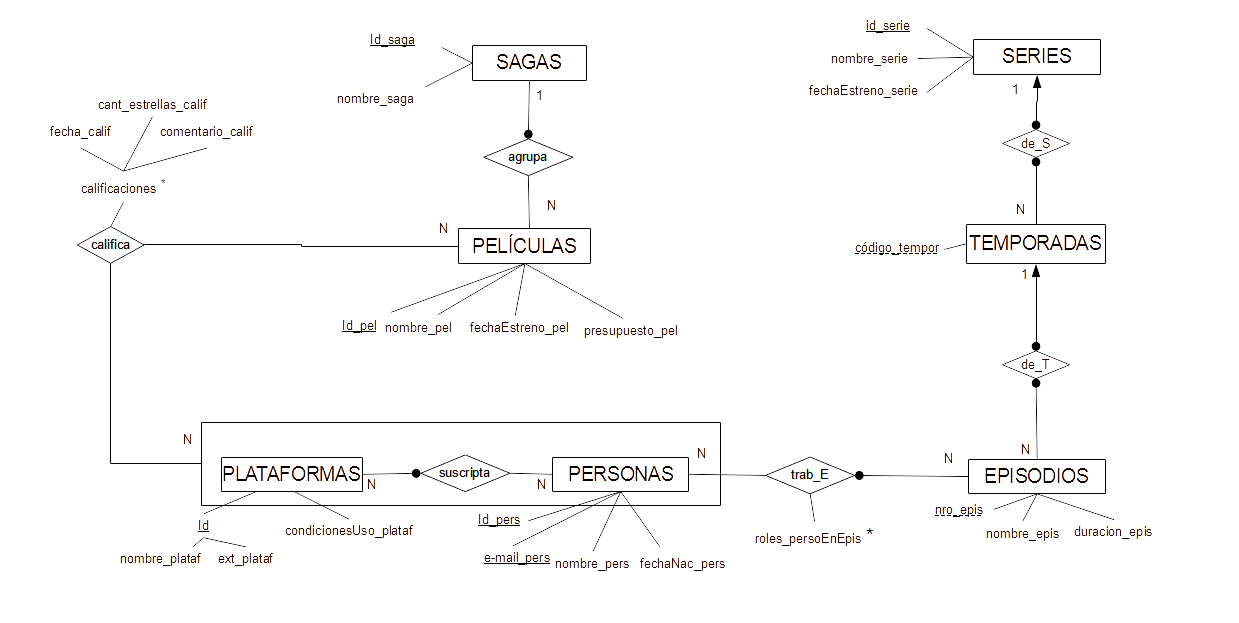


Se complementa el DER con las siguientes Restricciones No Estructurales (RNEs):

**RNE1:** Para todo episodio, su duración es mayor a 0.

$
(\forall e \in Episodios) (duracion(e) > 0)
$


**RNE2:** Para toda calificación, la cantidad de estrellas de la calificación es mayor o igual a 1 y menor o igual a 5, y la fecha de la calificación es mayor o igual a la fecha de la película.

$
(\forall pt \in Plataformas)(\forall p \in Personas)(\forall pl \in Peliculas) \\
    (<pt, p> \in suscripta \land <<pt, p>, pl> \in califica \\ 
        \rightarrow 
            (\forall c \in calificaciones(<<pt, p>, pl>)) 
                (cant\_estrellas\_calif(c) \geq 1 \land cant\_estrellas\_calif(c) \geq 5 \\
                \land fecha\_calif(c) \geq  fechaEstreno\_pel(pl)
                )                
     )
$

**RNE3:** Las calificaciones, de una persona suscripta a una plataforma a una misma película, no pueden tener 2 fechas de calificación iguales y que difieran en la cantidad de estrellas y/o en el comentario.

$
(\forall pt \in Plataformas)(\forall p \in Personas)(\forall pl \in Peliculas) \\
    (<pt, p> \in suscripta \land <<pt, p>, pl> \in califica \\ 
    \rightarrow 
       (
         (\forall c1 \in calificaciones(<<pt, p>, pl>))(\forall c2 \in calificaciones(<<pt, p>, pl>)) 
             (fecha\_calif(c1) = fecha\_calif(c2) \\
                \rightarrow cant\_estrellas\_calif(c1) = cant\_estrellas\_calif(c2) \land comentario\_calif(c1) = comentario\_calif(c2)
             )
       )
    )
$

## 1. Primer diseño de la base de datos miniMovies

A partir del relevamiento realizado, se generó un primer diseño relacional del esquema `miniMovies` que se presenta a continuación. <br>
**IMPORTANTE:** Notar que en este primer diseño, **no** se definieron claves primarias (_primary keys_) ni extranjeras o foráneas (_foreign keys_). 

    peliculas(
        id_pelicula,
        nombre_pelicula,
        fechaEstreno_pelicula,
        presupuesto_pelicula,
        id_saga,
        nombre_saga)

    calificaciones_peliculas(
        email_persona,
        nombre_plataf,
        ext_plataf,
        condicionesUso_plataf,
        nombre_pelicula,
        fecha_calif,
        cant_estrellas_calif,
        comentario_calif)

    personas_trabaja_episodios(
        id_persona,
        email_persona,
        nombre_persona,
        fechaNac_persona,
        nro_episodio,
        nombre_episodio,
        duracion_episodio,
        roles_personaEnEpisodio,
        codigo_temporada,
        id_serie,
        nombre_serie,
        fechaEstreno_serie)

### Actividad 1

Analice el diseño enfocado en identificar los problemas que presenta, en particular aquellos que provocan **anomalías de modificación** (ver Capítulo 14 de la referencia [EN, 2016] mencionada en la sección "Referencias y material de consulta" más arriba). 
Explique brevemente una anomalía en el caso de inserción, otra en el caso de borrado y otra en caso de modificación.

**Resultado actividad 1:** 

En general, se observa que conviven en la misma tabla varias entidades del MER (que se encuentran por separado). Esto genera una semántica confusa para las tablas, ya que por ejemplo personas_trabaja_episodio es la única tabla que contiene la información de una persona, mientras que es posible que una persona simplemente puede ser usuario de una plataforma y no participar de una película.

Para profundizar el análisis vemos algunos ejemplos de anomalías:

**Anomalía de inserción**: *No es posible agregar una plataforma a la base de datos sin agregar una calificación.

**Anomalía de borrado**:
El borrado del registro de todas las calificaciones correspondientes a una plataforma en calificaciones_peliculas resulta en la perdida de la información de la plataforma. No existe ninguna restricción que obligue a alguna película de la plataforma a tener una película por lo que podrían existir plataformas con películas no representadas.


**Anomalía de modificación**: 
Al querer modificar la duración de un episodio es necesario modificar todas las tuplas de personas_trabaja_episodios cambiandole el atributo duracion_episodio.


# 2 Consultas exploratorias sobre una instancia de la base del primer diseño

En esta sección se propone la realización de algunas consultas para analizar dependencias funcionales en una instancia. Comenzaremos por crear y cargar la base.  


## 2.1 Creación y carga de la base de datos
Crear y poblar esta base de datos a partir de los scripts que están en el EVA del curso.


## 2.2 Consultas 


### Actividad 2: Dependencias funcionales

Se quiere escribir consultas para verificar si algunas dependencias funcionales se satisfacen para esta instancia. 

1. Considere verificar la DF: 
> id_pelicula $\rightarrow$ nombre_pelicula, fechaEstreno_pelicula, presupuesto_pelicula 
     1. Escriba una consulta sql simple (la proyección) que devuelva los datos de los atributos involucrados en la DF (_id_pelicula, nombre_pelicula, fechaEstreno_pelicula, presupuesto_pelicula_) y observar el resultado obtenido para verificar si se satisface la DF. 
     2. Escriba una consulta sql mejorada que permita verificar la DF sin tener que examinar exhaustivamente todos los datos como en el caso anterior. Suponga que esta consulta se va a utilizar sobre una tabla que tenga miles o millones de tuplas.

### Resultado Actividad 2 - Parte 1.A
```sql
select id_pelicula, nombre_pelicula, fechaestreno_pelicula, presupuesto_pelicula 
from peliculas 
order by id_pelicula
```

### Resultado Actividad 2 - Parte 1.B
```sql
select p.id_pelicula, p.nombre_pelicula, p.fechaestreno_pelicula, p.presupuesto_pelicula 
from peliculas p
where exists(
	select 1
	from peliculas p1
	where p1.id_pelicula = p.id_pelicula and (p1.nombre_pelicula <> p.nombre_pelicula or 
											 p1.fechaestreno_pelicula <> p.fechaestreno_pelicula or
											 p1.presupuesto_pelicula <> p.presupuesto_pelicula)
	)
order by p.id_pelicula
```

2. Verifique la DF siguiente usando su idea de la parte 1B aplicada a este caso.
> nro_episodio, codigo_temporada, id_serie $\rightarrow$ duracion_episodio <br>

Inspeccione lo necesario para comprobar el resultado obtenido y explique brevemente porqué es el resultado esperado.

### Resultado Actividad 2 - Parte 2
```sql
select pte.nro_episodio, pte.codigo_temporada, pte.id_serie,duracion_episodio 
from personas_trabaja_episodios pte
where exists(
	select 1
	from personas_trabaja_episodios pte1
	where pte.nro_episodio = pte1.nro_episodio and 
		pte.codigo_temporada = pte1.codigo_temporada and 
		pte.id_serie = pte1.id_serie and
		pte.duracion_episodio <> pte1.duracion_episodio
	)
```


La consulta busca encontrar si existe un par de tuplas cuyos datos de episodio, temporada, e id_serie sean iguales, pero que su duración sea distinta. Esto incumpliría la DF presentada.

3. Verifique la DF siguiente usando su idea de la parte 1B aplicada a este caso. 
> nombre_plataf, ext_plataf $\rightarrow$ condicionesUso_plataf <br>

Inspeccione lo necesario para comprobar el resultado obtenido y explique brevemente porqué es el resultado esperado.

### Resultado Actividad 2 - Parte 3
```sql
select cp.nombre_plataf, cp.ext_plataf, cp.condicionesUso_plataf
from calificaciones_peliculas cp
where exists(
	select 1
	from calificaciones_peliculas cp1
	where cp.nombre_plataf = cp1.nombre_plataf and 
		cp.ext_plataf = cp1.ext_plataf and 
		cp.condicionesUso_plataf <> cp1.condicionesUso_plataf
	)
```

Se modifica la consulta de la parte anterior siguiendo la misma lógica y teniendo en cuenta la nueva DF presentada.

## 3. Join sin pérdida, Preservación de dependencias, Formas normales

### Actividad 3.1

Escribir en la celda a continuación todas las dependencias funcionales (DF) que se cumplen en esta realidad, a partir del Modelo de Entidad-Relación. Evitar redundancia tanto de atributos como de dependencias funcionales.

**Resultado actividad 3.1:** 

{
Personas:
 id_per $\rightarrow$ e-mail_pers, nombre_pers, fechaNac_pers; <br>
 e-mail_pers $\rightarrow$ id_per; <br>
 
Series:
 id_serie $\rightarrow$ fechaEstreno_serie, nombre_serie; <br>
 
Sagas:
 id_saga $\rightarrow$ nombre_saga; <br>
 
Películas:
 id_pel $\rightarrow$ nombre_pel, fechaEstreno_pel, presupuesto_pel, id_saga; <br>
 
Plataforma:
 nombre_plataf, ext_plataf  $\rightarrow$ condicionesUso_plataf; <br>
 
Episodios:
 id_serie, codigo_tempor, nro_epis $\rightarrow$ nombre_epis, duracion_epis; <br>
 
Califica:
 id_pel, id_pers, nombre_plataf, ext_plataf, fecha_calif $\rightarrow$ cant_estrellas_calif, comentario_calif; <br>}
 

### Actividad 3.2

Considere la siguiente descomposición del esquema `miniMovies` consistente en las 2 relaciones siguientes:

     R1(id_pelicula,
        nombre_pelicula,
        fechaEstreno_pelicula,
        presupuesto_pelicula,
        id_saga,
        nombre_saga,
        email_persona,
        nombre_plataf,
        ext_plataf,
        condicionesUso_plataf,
        fecha_calif,
        cant_estrellas_calif,
        comentario_calif)

     R2(id_persona,
        email_persona,
        nombre_persona,
        fechaNac_persona,
        nro_episodio,
        nombre_episodio,
        duracion_episodio,
        roles_personaEnEpisodio,
        codigo_temporada,
        id_serie,
        nombre_serie,
        fechaEstreno_serie)

1. Determine las dependencias funcionales de la Actividad 3.1 que se proyectan en cada una de las 2 relaciones R1 y R2. 
1. Verifique si la descomposición (R1, R2) cumple las propiedades de join sin pérdida (JSP) y preservación de dependencias.

**Resultado actividad 3.2:**
### Parte 1
#### Proyección en R1
 id_saga $\rightarrow$ nombre_saga; <br>
 id_pel $\rightarrow$ nombre_pel, fechaEstreno_pel, presupuesto_pel, id_saga; <br>
 nombre_plataf, ext_plataf  $\rightarrow$ condicionesUso_plataf; <br>
 id_pel, id_pers, nombre_plataf, ext_plataf, fecha_calif $\rightarrow$ cant_estrellas_calif, comentario_calif; <br>
 
#### Proyección en R2
 id_pers $\rightarrow$ e-mail_pers, nombre_pers, fechaNac_pers; <br>
 e-mail_pers $\rightarrow$ id_pers; <br>
 id_serie $\rightarrow$ fechaEstreno_serie, nombre_serie; <br>
 id_serie, codigo_tempor, nro_epis $\rightarrow$ nombre_epis, duracion_epis; <br>
 
 ### Parte 2
Para verificar si la descomposición (R1, R2) cumple con JSP es suficiente verificar la siguiente propiedad:
	$D=(R_1,R_2)$ de $R$ cumple con $JSP$ respecto a $F$ sobre $R$ $sii$:
		- la $df$ $(R_1 \cup R_{2})\rightarrow (R_1-R_2)$ esta en $F+$
		o
		- la $df$ $(R_1 \cup R_{2})\rightarrow (R_2-R_1)$ esta en $F+$

Veamos si la verifica: 

$R_{1} \cap R_{2}$ = {email_persona}<br>
$R_{2} - R_{1}$ = {id_persona, nombre_persona, fechaNac_persona, nro_episodio, nombre_episodio, duracion_episodio, roles_personaEnEpisodio, codigo_temporada, id_serie, nombre_serie, fechaEstreno_serie\} <br>
$R_{1} - R_{2}$ = {id_pelicula, nombre_pelicula, fechaEstreno_pelicula, presupuesto_pelicula, id_saga, nombre_saga, nombre_plataf, ext_plataf, condicionesUso_plataf, fecha_calif, cant_estrellas_calif, comentario_calif} <br>

Calcularemos la clausura de email_persona bajo F siendo F el conjunto de todas las dependencias funcionales:
$\{email\_persona\}^{+} = \{email\_persona, nombre\_persona, fechaNac\_persona\}$

Entonces no se cumple que:  
$R_{1} \cap R_{2} \to R_{2} - R_{1}$, que es equivalente a:

{email_persona} $\to$ {id_persona, nombre_persona, fechaNac_persona, nro_episodio, nombre_episodio, duracion_episodio, roles_personaEnEpisodio, codigo_temporada, id_serie, nombre_serie, fechaEstreno_serie}

Hay dependencias que no pertenecen a $F^{+}$, como por ejemplo $email\_persona \rightarrow nombre\_episodio$ ya que $nombre\_episodio \nsubseteq \{email\_persona\}^{+}$ bajo F.

Veamos que tampoco se cumple que
$R_{1} \cap R_{2} \to R_{2} - R_{1} \Rightarrow$  {email_persona} $\to$ {id_pelicula, nombre_pelicula, fechaEstreno_pelicula, presupuesto_pelicula, id_saga, nombre_saga, nombre_plataf, ext_plataf, condicionesUso_plataf, fecha_calif, cant_estrellas_calif, comentario_calif}

Hay dependencias deducibles de $R_{1} \cap R_{2} \to R_{2} - R_{1}$ que no pertenecen a $F^{+}$, como por ejemplo $email\_persona \rightarrow fechaEstreno\_pelicula$ ya que $fechaEstreno\_pelicula \nsubseteq \{email\_persona\}^{+}$ bajo F.

Como no se cumple la propiedad mencionada se puede asegurar que la desmposición (R1, R2) no cumple con JSP.

Por otro lado: la descomposición $D = (R1, R2)$ de $R$ preserva las dependencias respecto a $F$ si se cumple: $ ((\Pi_{R1}(F)) \cup (\Pi_{R_2}(F)))+ = F+ $, como $(\Pi_{R1}(F)) \cup (\Pi_{R_2}(F)) = F$ (información obtenida en parte 1)  $\rightarrow ((\Pi_{R1}(F)) \cup (\Pi_{R_2}(F)))+ = F+$ por lo tanto D preserva la dependencias respecto a $F$.

### Actividad 3.3

Determine la forma normal en que se encuentra cada relación R1 y R2 de la actividad 3.2, y luego indique la forma normal en que se encuentra el esquema `miniMovies` consistente en las relaciones R1 y R2. 

**Resultado actividad 3.3:**

Para poder determinar la forma normal en la que se encuentra cada $er$ tendremos en cuenta las siguientes definiciones:

$Def_1$:Una $er$ está em $1NF$ Los dominios de los atributos deben incluir solo valores atómicos (los atributos no pueden ser multivaluados ni compuestos)

$Def_2$: Un $er$ esta en $2NF$ si ningun atributo no primo $A$ de $R$ depende parcialmente de cualquier clave de $R$.

Calculamos las claves de $R_1$ y $R_2$:

$C_{R_1}$ = id_pelicula, e-mail_persona, nombre_plataf, ext_plataf, fecha_calif

$C_{R_2}$ = email_persona, id_serie, codigo_temporada, nro_episodio, roles_personaEnEpisodio

#### Forma normal de $R_1$
Se tiene dentro de las DF proyectadas por R1 a: id_pel $\rightarrow$ nombre_pel. nombre_pel es un atributo no primo ya que el mismo no forma parte de ninguna clave, además id_pel pertenece a $C_{R_1}$ y nombre_pel depende parcialmente de $C_{R_1}$ dado que es determinada por id_pel. Además se encuentra en 1FN ya que todos los atributos incuyen valores atómicos.

Entonces la relación R1 se encuentra en 1FN, pues se cumple $Def_1$ y no se cumple $Def_2$.

#### Forma normal de $R_2$

Se observa que la relación R2 se encuentra en 1FN. Esto se deduce porque se cumple $Def_1$ y no se cumple $Def_2$.

Dado que se cumple la siguiente DF: id_serie $\rightarrow$ nombre_serie, analogamente al caso anterior id_serie determina parcialmente a nombre_serie por lo que no se está en 2FN. Cumpliendose también $Def_1$ sobre $R_2$. 

#### Forma normal de miniMovies
La forma normal de miniMovies es 1FN ya que es la minima forma entre las tablas del esquema.


## 4. Diseño de la nueva base de datos miniMovies

### Actividad 4

1. Aplicando **sólo** algoritmos de normalización vistos en el curso, proponga un nuevo diseño para la base `miniMovies` que se encuentre en BCNF y que cumpla la propiedad de JSP. Verifique si preserva dependencias funcionales.
2. Implemente el diseño propuesto, incluyendo claves primarias, claves alternativas y dependencias de clave foránea.
2. Implemente, utilizando _triggers_, el control de la restricción no estructural 2 (RNE2), al momento de la inserción de calificaciones. En caso de que no se satisfaga se debe impedir la inserción emitiendo un mensaje explicando el motivo.
2. Provea scripts con sentencias SQL que permitan chequear el/los triggers implementados, en casos donde se cumpla y no se cumpla la restricción controlada.


**Resultado actividad 4:**

#### Aplicación del algoritmo BCNF para miniMovies

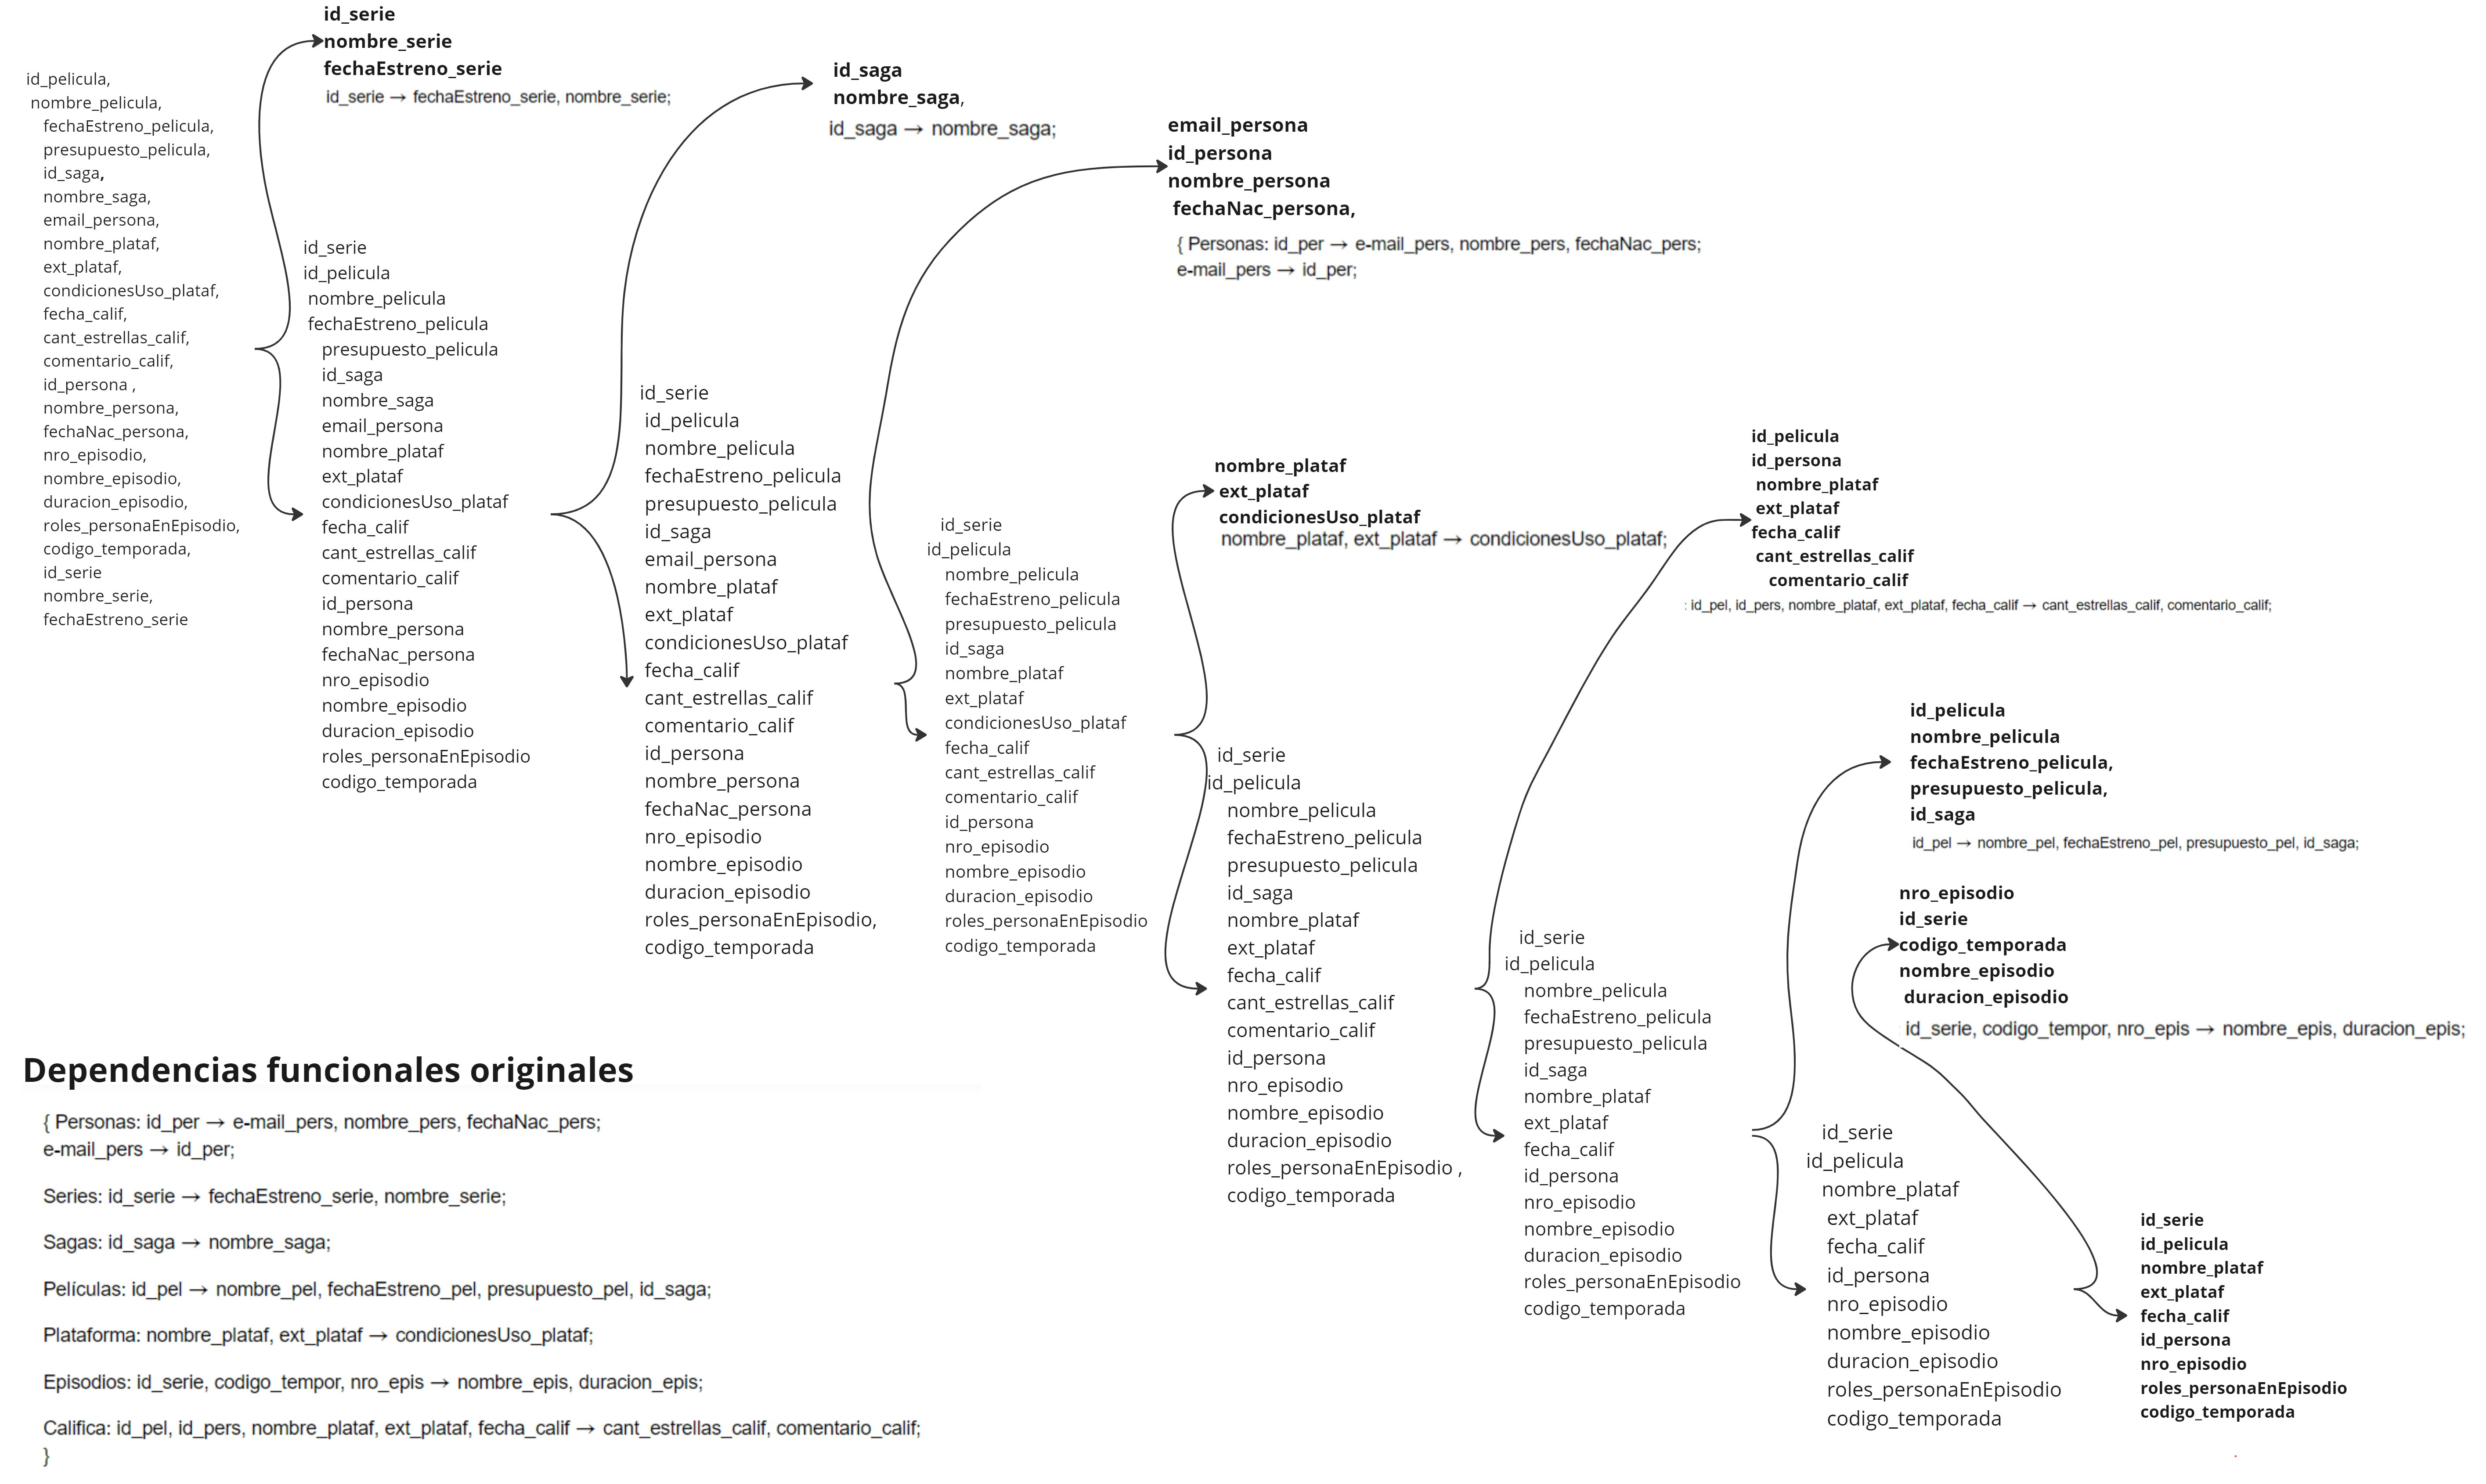

Aclaración:
    Las dependencias funcionales de las tablas inferiores no se incluyen por claridad visual. Las mismas consisten en las DF de la tabla anterior menos las de la nueva tabla superior

### Propuesta de diseño para miniMovies
(Resultado final de la parte anterior)

Nota: 
1. Se utilizará **negrita** para indicar el atributo que es clave de cada una de las tablas
2. Se utilizará *cursiva* para indicar las claves alternativas

Series(**id_serie**, nombre_serie, fechaEstreno_serie)

- id_serie $\rightarrow$ nombre_serie, fechaEstreno_serie

Calificaciones_Peliculas(**id_pelicula, id_persona, nombre_plataf, ext_plataf, fecha_calif**, cant_estrellas_calif, comentario_calif)

- id_pelicula, id_persona, nombre_plataf, ext_plataf, fecha_calif $\rightarrow$ camt_estrellas_calif, comentario_calif

Persona_Trabaja_Califica(id_serie, id_pelicula, nombre_plataf, ext_plataf, fecha_calif, id_persona, nro_episodio, roles_personaEnEpisodio, codigo_temporada)

Episodio_en_Serie(**nro_episodio, codigo_temporada, id_serie**, nombre_episodio, duracion_episodio)

- id_serie, codigo_temporada, nro_episodio $\rightarrow$ nombre_episodio, duracion_episodio

Sagas(**id_saga**, nombre_saga)

- id_saga $\rightarrow$ nombre_saga

Personas(**email_persona**, *id_persona*, nombre_persona, fechaNac_persona)

- email_persona $\rightarrow$ id_persona, nombre_persona, fechaNac_persona
- id_persona $\rightarrow$ email_persona

Plataformas(**nombre_plataf, ext_plataf**, condicionesUso_plataf)

- nombre_plataf, ext_plataf $\rightarrow$ condicionesUso_plataf

Peliculas(**id_pelicula**, nombre_pelicula, fechaEstreno_pelicula, presupuesto_pelicula, id_saga)

- id_pelicula $\rightarrow$ nombre_pelicula, fechaEstreno_pelicula, presupuesto_pelicula, id_saga

Como la unión de las dependencias funcionales de cada una de las tablas de la descomposicón es igual a las dependencias funcionales de R, se tiene que se conservan las mismas. Por otro lado como el algoritmo utilizado para la contrucción de la descomposición es el de BCNF con JSP se puede asegurar que cumple la propiedad de JSP.

### Script de creación 
```sql
SET statement_timeout = 0;
SET lock_timeout = 0;
SET idle_in_transaction_session_timeout = 0;
SET client_encoding = 'UTF8';
SET standard_conforming_strings = on;
SELECT pg_catalog.set_config('search_path', '', false);
SET check_function_bodies = false;
SET xmloption = content;
SET client_min_messages = warning;
SET row_security = off;

SET statement_timeout = 0;
SET lock_timeout = 0;
SET idle_in_transaction_session_timeout = 0;
SET client_encoding = 'UTF8';
SET standard_conforming_strings = on;
SELECT pg_catalog.set_config('search_path', '', false);
SET check_function_bodies = false;
SET xmloption = content;
SET client_min_messages = warning;
SET row_security = off;

SET default_tablespace = '';

SET default_table_access_method = heap;

CREATE TABLE public.series (
    id_serie bigint,
    nombre_serie text,
    fechaEstreno_serie date,
    PRIMARY KEY(id_serie)
);

CREATE TABLE public.sagas(
    id_saga bigint,
    nombre_saga text,
    PRIMARY KEY(id_saga)
    );

CREATE TABLE public.peliculas(
    id_pelicula bigint,
    nombre_pelicula text,
    fechaEstreno_pelicula date,
    presupuesto_pelicula numeric,
    id_saga bigint,
    PRIMARY KEY(id_pelicula),
    FOREIGN KEY(id_saga) REFERENCES public.sagas(id_saga)
    );


CREATE TABLE public.plataformas(
    nombre_plataf text,
    ext_plataf text,
    condicionesUso_plataf text,
    PRIMARY KEY(nombre_plataf, ext_plataf)
    );


CREATE TABLE public.personas(
    id_persona bigint,
	email_persona text NOT NULL,
    nombre_persona text,
    fechaNac_persona date,
    PRIMARY KEY(id_persona),
    UNIQUE(email_persona)
    );

CREATE TABLE public.calificaciones_peliculas (
    id_pelicula bigint,
    id_persona bigint,
    nombre_plataf text,
    ext_plataf text,
    fecha_calif date,
    cant_estrellas_calif numeric,
	comentario_calif text,
    PRIMARY KEY(id_pelicula, id_persona, nombre_plataf, ext_plataf, fecha_calif),
    FOREIGN KEY(id_pelicula) REFERENCES public.peliculas(id_pelicula),
    FOREIGN KEY(id_persona) REFERENCES public.personas(id_persona),
    FOREIGN KEY(nombre_plataf, ext_plataf) REFERENCES public.plataformas(nombre_plataf, ext_plataf)
);


CREATE TABLE public.episodio_en_serie(
    nro_episodio numeric, 
    codigo_temporada numeric,
    id_serie bigint,
    nombre_episodio text,
    duracion_episodio numeric,
    PRIMARY KEY(nro_episodio, codigo_temporada, id_serie),
    FOREIGN KEY(id_serie) REFERENCES public.series(id_serie)
);

CREATE TABLE public.persona_trabaja_califica(
    id_serie bigint,
    id_pelicula bigint,
    nombre_plataf text,
    ext_plataf text,
    fecha_calif date,
    id_persona bigint,
    nro_episodio numeric,
    roles_personaEnEpisodio text,
    codigo_temporada numeric,
    FOREIGN KEY(id_serie, codigo_temporada, nro_episodio) REFERENCES public.episodio_en_serie(id_serie, codigo_temporada, nro_episodio),
    FOREIGN KEY(id_pelicula, id_persona, nombre_plataf, ext_plataf, fecha_calif) REFERENCES public.calificaciones_peliculas(id_pelicula, id_persona, nombre_plataf, ext_plataf, fecha_calif)
);
```
 

### Declaración de triggers y funciones asociadas

```sql
CREATE FUNCTION tg_rne2() RETURNS TRIGGER
AS
$$
BEGIN
    IF (NEW.cant_estrellas_calif > 5 OR NEW.cant_estrellas_calif < 1) THEN
        RAISE EXCEPTION 'La cantidad de estrellas debe ser mayor o igual que 1 y menor o igual que 5, el valor ingresado es: %', NEW.cant_estrellas_calif;
    END IF;
	
	IF((SELECT pel.fechaestreno_pelicula FROM peliculas pel WHERE pel.id_pelicula = new.id_pelicula) > NEW.fecha_calif) THEN
		RAISE EXCEPTION 'La fecha de la calificación debe ser posterior a la fecha de estreno de la película, el valor ingresado es: %', NEW.fecha_calif;
	END IF;
return new; -- va con new para decirle que se puede seguir ejecutando todo con la nueva información
END
$$
LANGUAGE plpgsql;

-----------------

CREATE TRIGGER tr_insert BEFORE INSERT OR UPDATE ON "calificaciones_peliculas" 
FOR EACH ROW
EXECUTE PROCEDURE tg_rne2();
```

### Carga de datos de prueba

```sql

INSERT INTO public.sagas(
	id_saga, nombre_saga)
	VALUES (1, 'Star Wars');
	

INSERT INTO public.peliculas(
	id_pelicula, nombre_pelicula, fechaestreno_pelicula, presupuesto_pelicula, id_saga)
	VALUES (11, 'Star Wars: Episode IV – A New Hope', '1977-05-25', 11000000, 1);

INSERT INTO public.plataformas(
	nombre_plataf, ext_plataf, condicionesUso_plataf)
	VALUES ('Disney', 'com', 'Condiciones de uso GENERICAS');

INSERT INTO public.personas(
	id_persona, email_persona, nombre_persona, fechanac_persona)
	VALUES (1,'natalie.alaniz@fing.edu.uy', 'Valentina', '2002-02-02');

INSERT INTO public.calificaciones_peliculas(
	id_pelicula, id_persona,nombre_plataf, ext_plataf,fecha_calif, cant_estrellas_calif, comentario_calif)
	VALUES (11, 1, 'Disney', 'com', '2016-08-02', 5, 'Que bien!')

```
### Calificación con error por fecha no válida
```sql
INSERT INTO public.calificaciones_peliculas(
	id_pelicula, id_persona,nombre_plataf, ext_plataf,fecha_calif, cant_estrellas_calif, comentario_calif)
	VALUES (11, 1, 'Disney', 'com', '1900-08-02', 5, 'Que mal! No anda la calificación por la fecha')
 
```

### Calificación con error por cantidad de estrellas no válida
```sql	
INSERT INTO public.calificaciones_peliculas(
	id_pelicula, id_persona,nombre_plataf, ext_plataf,fecha_calif, cant_estrellas_calif, comentario_calif)
	VALUES (11, 1, 'Disney', 'com', '2022-08-02', 10, 'Que mal! No anda la calificación por la cantidad de estrellas')
```

### Modificación inválida de fecha
```sql
UPDATE public.calificaciones_peliculas
SET fecha_calif = '1900-02-02'
WHERE id_pelicula = 11 AND id_persona = 1 AND nombre_plataf = 'Disney' and ext_plataf = 'com' and fecha_calif = '2016-08-02'
```

### Modificación inválida por cantidad de estrellas
```sql
UPDATE public.calificaciones_peliculas
SET cant_estrellas_calif = 11
WHERE id_pelicula = 11 AND id_persona = 1 AND nombre_plataf = 'Disney' and ext_plataf = 'com' and fecha_calif = '2016-08-02'
```

### Modificaciones válidas
```sql
UPDATE public.calificaciones_peliculas
SET fecha_calif = '2002-02-02'
WHERE id_pelicula = 11 AND id_persona = 1 AND nombre_plataf = 'Disney' and ext_plataf = 'com' and fecha_calif = '2016-08-02'

UPDATE public.calificaciones_peliculas
SET cant_estrellas_calif = 1, comentario_calif = 'orivle!!!'
WHERE id_pelicula = 11 AND id_persona = 1 AND nombre_plataf = 'Disney' and ext_plataf = 'com' and fecha_calif = '2002-02-02'

```